## Downloading the dataset

In [1]:
#Loading packages
import pandas as pd
import numpy as np
import urllib.request
import shutil
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.ndimage import uniform_filter1d
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('..')

#add by twx
from plot_utils_China import download_China_data_github,maxc,\
    load_CN_borders,load_CN_faluts,plot_faluts,plot_borders,azimuthal_equidistant_projection,points

from scipy.stats import linregress
from shapely.validation import explain_validity


# Custom Colormap
colors = ["#5F0F40", "#C9DAEA", "#84A07C", "#E36414", "#39A9DB", "#0081A7", "#284B63", "#FFD449"]

In [2]:
# Download Parameters(for download_USGS_data and download_China_data_CENC)
start_year, start_month,start_day = 1970, 1, 1
end_year, end_month,end_day = 2024, 1, 1
max_lat, min_lat, max_lon, min_lon = 35, 20, 110, 95# 经纬度范围
minimum_magnitude, maximum_magnitude = 0.0, 10.0  # 震级范围

In [3]:
#Download data from website
filenames = download_China_data_github()

# filenames = download_China_data_CENC(start_year, start_month,start_day,end_year, end_month,end_day,max_lat, min_lat, max_lon, min_lon,minimum_magnitude)
# combine_csv_files(filenames,f"raw/{start_year}_{end_year}.csv")

# #filename = download_USGS_data(start_year,start_month,end_year,end_month, max_lat, min_lat, max_lon, min_lon, minimum_magnitude)

we can now read and fiter the data

In [3]:
# 读取数据
raw_catalog = pd.read_csv('data/raw/CSES_0.csv')
print(len(raw_catalog))
raw_catalog['Time'] = pd.to_datetime(raw_catalog['Time'])
# print(raw_catalog['Time'].dtype)  # 查看时间列的时区


# # 按时间排序并重置索引,避免有数据排序错乱
raw_catalog = raw_catalog.sort_values(by='Time')
raw_catalog.reset_index(drop=False, inplace=True)

# 重命名列
raw_catalog.rename(columns={'Time': 'time', 'Longitude': 'longitude', 'Latitude': 'latitude',
                            'Magnitude': 'magnitude', 'Depth': 'depth','index': 'Id'}, inplace=True)
raw_catalog.head()

# # 只保留指定的列，并删除缺失值
filtered_catalog = raw_catalog[["Id","time", "longitude", "latitude", "magnitude"]].dropna()


#put the filtered datamove to a new file
os.makedirs("/home/tianweixi/Programe/EarthquakeNPP_CSEP_China/Datasets/CENC/data/fitered", exist_ok=True)
filtered_catalog.to_csv(f"data/fitered/fitered_CSES_0.csv", index=False, encoding='utf-8')

# 查看前5行筛选后的数据
print('fitered catalog has:',len(filtered_catalog),'event')
filtered_catalog.head()





911169
fitered catalog has: 911169 event


,Id,time,longitude,latitude,magnitude
0,0,1970-01-01 12:55:00,100.98,26.05,2.7
1,1,1970-01-05 01:00:00,102.60,24.10,7.8
2,2,1970-01-05 01:32:00,102.45,24.20,5.6
3,3,1970-01-05 01:46:00,102.45,24.20,4.4
4,4,1970-01-05 01:57:00,102.45,24.20,4.3


## Visualising the Catalog

Let's plot events in the raw catalog over time along with an estimate of the completeness using Maximum Curvature [2].
We can see significant improvements that were made to the network after 2002. By 2012 it appears to be relatively stable.

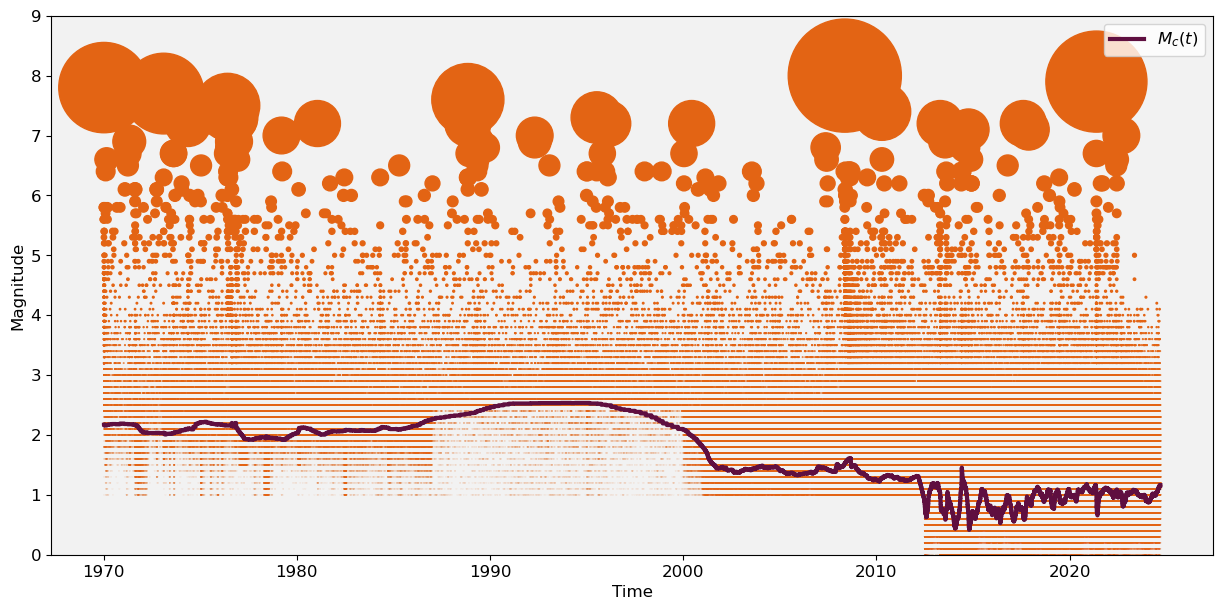

In [4]:
%matplotlib inline
plt.figure(figsize=(15, 7)) # the size of figure
plt.gca().set_facecolor((0.95, 0.95, 0.95)) # get current axis(gca), set the face color

# Compute M_c(t) across the filetred catalog
window_size=300
nwindows = math.floor(len(filtered_catalog['magnitude'])/window_size) #calculate the number of windows


Mc_t = [0]*nwindows
mid_time = [0]*nwindows

comp_T = filtered_catalog['time']
comp_M = filtered_catalog['magnitude']

for i in range(nwindows): #依次获取每个window包含的地震震级信息，并输入（震级，震级间隔）到maxc进行计算
    
    mid_time[i] =  pd.Timestamp(pd.Series(comp_T[i*window_size:(i+1)*window_size]).mean())

    window = comp_M[i*window_size:(i+1)*window_size] 
    Mc_t[i] = maxc(window,0.05)

# Smooth M_c(t) for plotting
Mc_t = uniform_filter1d(Mc_t, size=40)

# Plotting
plt.step(mid_time,Mc_t,colors[0],label=r'$M_c(t)$',lw=3)
z = (9.5**filtered_catalog['magnitude'])*0.0001
plt.scatter(filtered_catalog['time'],filtered_catalog['magnitude'],s=z,color =colors[3])
plt.xlabel('Time',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0,9.0)
# save the figure
os.makedirs("data/Figure", exist_ok=True)
plt.savefig('data/Figure/1.MC.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

## Plot the CSES, CSEP_TEST, CSEP_COLLECTION Region 

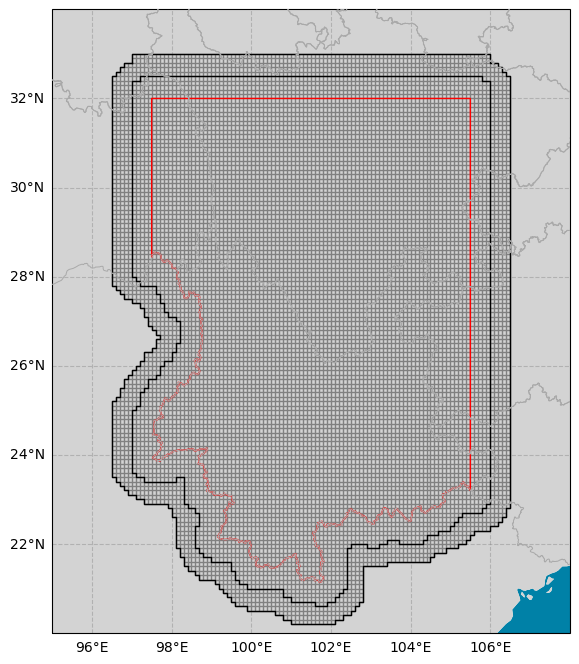

In [5]:
# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) #添加底图并设置投影方式为mercator投影
max_lat_plot, min_lat_plot, max_lon_plot, min_lon_plot = 34, 20, 108, 95# 经纬度范围,这是绘图的范围,不太一样
ax.set_extent([min_lon_plot, max_lon_plot, min_lat_plot, max_lat_plot], crs=ccrs.PlateCarree()) #设定范围，并设定为平面等距投影，也就是平常所用的经纬度书韩剧就可以


# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16) #设置刻度参数
ax.tick_params(axis='y', labelsize=16)


# 读取网格文件
grid_file_path = 'data/Grid_files/COLLECTION_GRID_Clip_Clip1.shp'  # 替换为你的网格文件路径
grid_gdf = gpd.read_file(grid_file_path)

# 设置初始的 CRS (假设是 WGS84 坐标系)
grid_gdf = grid_gdf.set_crs(epsg=4326)

# 绘制网格
grid_gdf.plot(ax=ax, color=None, edgecolor='gray', lw=1.0)

# Plot collection polygon
polygon_coords_collection = np.load('data/CSEP_COLLECTION_REGION.npy')
plot_polygon_coords_collection = np.append(polygon_coords_collection, [polygon_coords_collection[0]], axis=0)
ax.plot(plot_polygon_coords_collection[:, 1], plot_polygon_coords_collection[:, 0], transform=ccrs.PlateCarree(), color='black', lw=1.0) #这里的plot()中第一个参数是经度，第二个是纬度

# Plot test polygon
polygon_coords_test = np.load('data/CSEP_TEST_REGION.npy')
plot_polygon_coords_test = np.append(polygon_coords_test, [polygon_coords_test[0]], axis=0)
ax.plot(plot_polygon_coords_test[:, 1], plot_polygon_coords_test[:, 0], transform=ccrs.PlateCarree(), color='black', lw=1.0) #这里的plot()中第一个参数是经度，第二个是纬度

# Plot CSES polygon
polygon_coords = np.load('data/CSEP_China_Region_twx_arcgis.npy')
plot_polygon_coords = np.append(polygon_coords, [polygon_coords[0]], axis=0)
ax.plot(plot_polygon_coords[:, 1], plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color='red', lw=1.0) #这里的plot()中第一个参数是经度，第二个是纬度

# Add colored land and ocean, we need to plot them after plotting the event. Otherwise, it will be covered
ax.add_feature(cfeature.OCEAN.with_scale('50m'),facecolor="#0081A7")
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='#D3D3D3')

#Read borders and faluts file
# 读取border数据
file_path = 'data/CN-border-La.gmt'
borders = load_CN_borders(file_path)
plot_borders(borders,ax)

#保存图片
plt.savefig('data/Figure/0.Region.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

let's now visualise the coordinates of events in the catalog

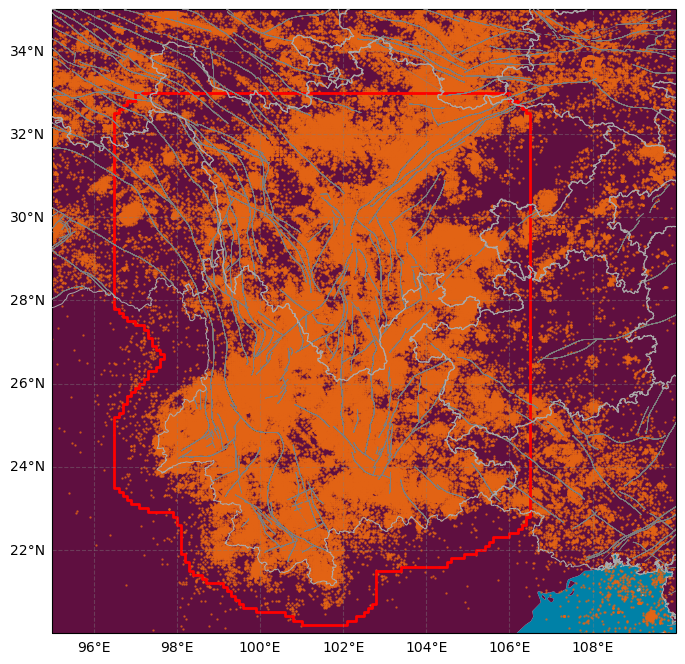

In [6]:
# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) #添加底图并设置投影方式为mercator投影
max_lat_plot, min_lat_plot, max_lon_plot, min_lon_plot = 35, 20, 110, 95# 经纬度范围,这是绘图的范围,不太一样
ax.set_extent([min_lon_plot, max_lon_plot, min_lat_plot, max_lat_plot], crs=ccrs.PlateCarree()) #设定范围，并设定为平面等距投影，也就是平常所用的经纬度书韩剧就可以


#Read borders and faluts file
# 读取border数据
file_path = 'data/CN-border-La.gmt'
borders = load_CN_borders(file_path)
# 读取faluts数据
file_path = 'data/CN-faults.gmt'
faluts = load_CN_faluts(file_path)

# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16) #设置刻度参数
ax.tick_params(axis='y', labelsize=16)

# Plot collection polygon
polygon_coords_collection = np.load('data/CSEP_COLLECTION_REGION.npy')
plot_polygon_coords_collection = np.append(polygon_coords_collection, [polygon_coords_collection[0]], axis=0)
ax.plot(plot_polygon_coords_collection[:, 1], plot_polygon_coords_collection[:, 0], transform=ccrs.PlateCarree(), color='red', lw=2.0) #这里的plot()中第一个参数是经度，第二个是纬度


# Plot events
ax.scatter(filtered_catalog['longitude'], filtered_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[3], alpha=0.8)

# Add colored land and ocean, we need to plot them after plotting the event. Otherwise, it will be covered
ax.add_feature(cfeature.OCEAN.with_scale('50m'),facecolor="#0081A7")
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="#5F0F40")

#绘制faluts和borders数据

plot_faluts(faluts,ax,min_lon_plot, max_lon_plot, min_lat_plot, max_lat_plot)
plot_borders(borders,ax)

#保存图片
plt.savefig('data/Figure/2.Event_and_Region.png', dpi=300, format='png', bbox_inches='tight')

plt.show()


## Truncating the catalog

For this catalog, we define the target region to be the same as the  CSEP-CN experiments.

In [7]:
#Time: 6分30秒
#filter events within polygon
# in_polygon = points(filtered_catalog.latitude, filtered_catalog.longitude)
in_polygon = points(filtered_catalog.longitude, filtered_catalog.latitude)
earthquakes_in_polygon = filtered_catalog[in_polygon]
len_trunc_x = len(earthquakes_in_polygon )
print('Removed',len(filtered_catalog)-len_trunc_x, 'events outside polygon')

# filter events within timewindow
auxiliary_start = '1970-01-01 00:00:00'
test_nll_end = '2024-09-01 00:00:00'
earthquakes_in_polygon = earthquakes_in_polygon[earthquakes_in_polygon['time']>=auxiliary_start]
earthquakes_in_polygon = earthquakes_in_polygon[earthquakes_in_polygon['time']<test_nll_end]
len_trunc_t = len(earthquakes_in_polygon)
print('Removed',len_trunc_x-len_trunc_t, 'events outside timewindow')

earthquakes_in_polygon.to_csv(f"data/fitered/truncated catalog_CSES_0.csv", index=False)

Removed 78614 events outside polygon
Removed 1022 events outside timewindow


### 过滤数据后,绘制过滤后的数据检查

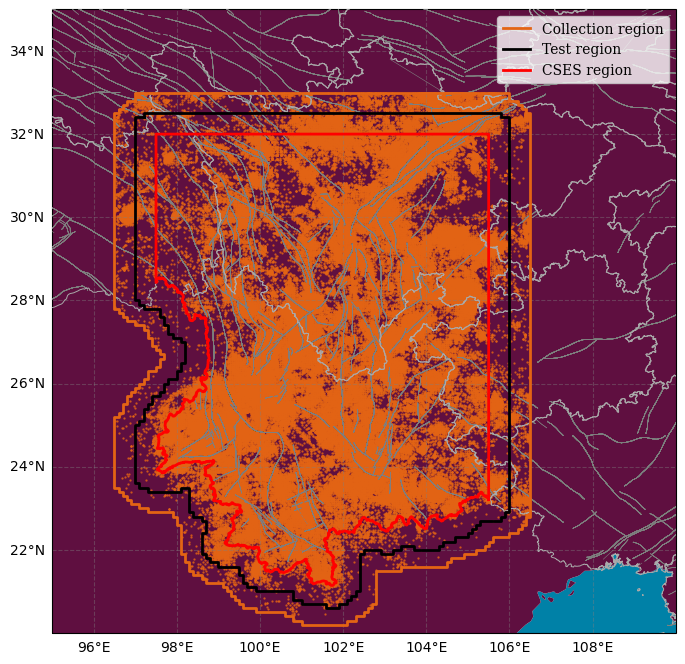

In [19]:
# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) #添加底图并设置投影方式为mercator投影
max_lat_plot, min_lat_plot, max_lon_plot, min_lon_plot = 35, 20, 110, 95# 经纬度范围,这是绘图的范围,不太一样
ax.set_extent([min_lon_plot, max_lon_plot, min_lat_plot, max_lat_plot], crs=ccrs.PlateCarree()) #设定范围，并设定为平面等距投影，也就是平常所用的经纬度书韩剧就可以


#Read borders and faluts file
# 读取border数据
file_path = 'data/CN-border-La.gmt'
borders = load_CN_borders(file_path)
# 读取faluts数据
file_path = 'data/CN-faults.gmt'
faluts = load_CN_faluts(file_path)

#绘制faluts和borders数据

plot_faluts(faluts,ax,min_lon_plot, max_lon_plot, min_lat_plot, max_lat_plot)
plot_borders(borders,ax)

# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16) #设置刻度参数
ax.tick_params(axis='y', labelsize=16)

# Plot collection polygon
polygon_coords_collection = np.load('data/CSEP_COLLECTION_REGION.npy')
plot_polygon_coords_collection = np.append(polygon_coords_collection, [polygon_coords_collection[0]], axis=0)
ax.plot(plot_polygon_coords_collection[:, 1], plot_polygon_coords_collection[:, 0], transform=ccrs.PlateCarree(), color=colors[3], lw=2.0,label = 'Collection region',zorder=101) #这里的plot()中第一个参数是经度，第二个是纬度

# Plot test polygon
polygon_coords_test = np.load('data/CSEP_TEST_REGION.npy')
plot_polygon_coords_test = np.append(polygon_coords_test, [polygon_coords_test[0]], axis=0)
ax.plot(plot_polygon_coords_test[:, 1], plot_polygon_coords_test[:, 0], transform=ccrs.PlateCarree(), color='black', lw=2.0,label = 'Test region',zorder=101) #这里的plot()中第一个参数是经度，第二个是纬度

# Plot CSES polygon
polygon_coords = np.load('data/CSEP_China_Region_twx_arcgis.npy')
plot_polygon_coords = np.append(polygon_coords, [polygon_coords[0]], axis=0)
ax.plot(plot_polygon_coords[:, 1], plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color='red', lw=2.0,label = 'CSES region',zorder=101) #这里的plot()中第一个参数是经度，第二个是纬度

# Plot events
ax.scatter(earthquakes_in_polygon['longitude'], earthquakes_in_polygon['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[3], alpha=0.8)

# Add colored land and ocean, we need to plot them after plotting the event. Otherwise, it will be covered
ax.add_feature(cfeature.OCEAN.with_scale('50m'),facecolor="#0081A7")
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="#5F0F40")

legend = ax.legend(loc="upper right",prop={'family': 'DejaVu Serif'})
legend.set_zorder(102)  # 将图例的层级提高

#保存图片
plt.savefig('data/Figure/3.Event_and_Region_truncated.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

We can now truncate the catalog above a magnitude threshold.

Let's look at the events in the earlier part of our catalog.

In [ ]:
# plotting params
plt.figure()
plt.gca().set_facecolor((0.95, 0.95, 0.95))
bins = 40
linew = 3

# histogram
# catalog = pd.read_csv('data/fitered/truncated catalog_CSES_0.csv')#这一步是用于测试时,避免要重复上一步花3分钟生成catalog
catalog_pre1990 = earthquakes_in_polygon[earthquakes_in_polygon['time']<'2024-01-01 00:00:00']
hist, bins = np.histogram(catalog_pre1990['magnitude'], bins=bins)
log_hist = np.log10(hist[hist > 0])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers[hist > 0]

plt.hist(catalog_pre1990['magnitude'], bins=bins, log=True, alpha=1, color=colors[0], label='Events 1970-2024')
plt.xlabel(r'Magnitude')
plt.ylabel('Frequency (log scale)')

# Fit a GR line to the log-transformed histogram data
mag_bin = 0.05
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, log_hist)
plt.plot(bin_centers, 10**(slope * bin_centers + intercept+0.07), 'r-',color = colors[2], label='GR Fit',linewidth=linew)
plt.axvline(x=1.5, color=colors[1], linestyle='--', label='Mc',linewidth=linew)
plt.legend()

plt.savefig('data/Figure/4.G_R_Fit.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

A sensible choice of threshold is where the histogram of events deviates from the Gutenberg-Richter law.

In this case at 1.0

In [ ]:
# filter events above magnitude threshold
Mcut = 1.0
len_trunc_t = len(earthquakes_in_polygon)
earthquakes_in_polygon = earthquakes_in_polygon[earthquakes_in_polygon['magnitude']>=Mcut]
len_trunc_m = len(earthquakes_in_polygon)
print('Removed',len_trunc_t-len_trunc_m, 'events below Mcut')
print(len(earthquakes_in_polygon))

## The Processed Catalog

Let's now plot the truncated catalog, including the training, validation and testing windows. We can also label some of the major events that occurred.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# time windows for training, validation, and testing
auxiliary_start = pd.Timestamp('1970-01-01 00:00:00')
training_start = pd.Timestamp('1986-01-01 00:00:00')
validation_start = pd.Timestamp('1999-01-01 00:00:00')
testing_start = pd.Timestamp('2013-01-01 00:00:00')
testing_end = pd.Timestamp('2024-01-01 00:00:00')

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_facecolor((0.95, 0.95, 0.95))

# Plotting earthquakes
z = (9.5 ** earthquakes_in_polygon['magnitude']) * 0.0001
scatter = ax.scatter(earthquakes_in_polygon['time'], earthquakes_in_polygon['magnitude'], s=z, color='black')

# 设置图形x轴上下限
xmin, xmax = pd.Timestamp('1969-12-01'), pd.Timestamp('2024-02-01')
ax.set_xlim(xmin, xmax)

# Highlighting time windows
alph = 0.4
ax.axvspan(xmin, training_start, color=colors[6], alpha=alph, label='Auxiliary', zorder=-100)
ax.axvspan(training_start, validation_start, color=colors[0], alpha=alph, label='Training', zorder=-100)
ax.axvspan(validation_start, testing_start, color=colors[2], alpha=alph, label='Validation', zorder=-100)
ax.axvspan(testing_start, xmax, color=colors[3], alpha=alph, label='Testing', zorder=-100)

#控制图外的备注和图形
trans = ax.get_xaxis_transform()
lineheight, textheight = -.13, -.18

# Annotations for train/val/test windows
#好像是每年365天,但是怎么这样画图我还不清楚
annotations = [
    ('Start', 0),
    ('Train Start', 5840),
    ('Val Start', 10585),
    ('Test Start', 15695),
    ('End', 19750),
]

for label, x_pos in annotations:
    ax.annotate(
        label, xy=(x_pos, lineheight), xycoords=trans, ha="center", va="top", fontsize=14,
        xytext=(x_pos, textheight), textcoords=trans, arrowprops=dict(arrowstyle='-', color='black', lw=2)
    )

ax.plot([xmin, xmax], [lineheight, lineheight], color="k", transform=trans, clip_on=False, lw=2)

# Event annotations
events = [
    ('1970-01-05', 'Tonghai', 'Yunnan', '7.8'),
    # ('1973-02-06', 'Luhuo', 'Sichuan', '7.7'),
    ('1976-05-29', 'Longling-double', 'Yunnan', '7.5'),
    ('1988-11-06', 'Canglan-Gengma', 'Yunnan', '7.6'),
    ('1996-02-03', 'Lijiang', 'Yunnan', '7.2'),
    ('2008-05-12', 'Wenchuan', 'Sichuan', '8.0'),
    ('2013-04-20', 'Lushan', 'Sichuan', '7.0'),
]

for date, name, location, magnitude in events:
    event_date = pd.Timestamp(date)
    magnitude = float(magnitude)
    ax.annotate(
        f'{name}\nMs {magnitude} \n {location}',
        xy=(event_date, magnitude),
        xytext=(10, 40),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=14,
        ha='center'
    )

# Labels and formatting
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.001, 1), fontsize=12)

plt.savefig('data/Figure/5.Time_Windows.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

Finally, since ETAS uses the great-circle distance between two points on a sphere (km), for the NPPs we need to project the coordinates of the events into a space such that inter-event distances are in km. To do this, we can use the Azimuthal equidistant projection [5], which preserves distances from all points to a center point.

We pass the mean coordinates of the catalog as the center coordinates of the projection.

In [12]:
center_latitude = earthquakes_in_polygon['latitude'].mean()  # Latitude of the center point
center_longitude = earthquakes_in_polygon['longitude'].mean()  # Longitude of the center point

# Convert latitude and longitude to Cartesian coordinates using Plate Carrée projection
earthquakes_in_polygon['x'], earthquakes_in_polygon['y'] = azimuthal_equidistant_projection(earthquakes_in_polygon['latitude'], earthquakes_in_polygon['longitude'], center_latitude, center_longitude)

## Finally, we get the pre-processed catalog

In [ ]:
# write this pre-processed catalog to file.
Final_catalog_path = 'data/Preprocessed_catalog'
if not os.path.exists(Final_catalog_path):
    os.makedirs(Final_catalog_path)
earthquakes_in_polygon.to_csv("data/Preprocessed_catalog/CSEP_CN_catalog.csv", index=False)
print(len(earthquakes_in_polygon))